In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from lingualytics.preprocessing import remove_lessthan,remove_punctuation,remove_stopwords
from lingualytics.stopwords import hinglish_stopwords,hi_stopwords

import string,re

In [ ]:
import pycld2 as cld2

time: 5.69 ms (started: 2021-09-02 07:35:00 +00:00)


In [ ]:
# language detection to detect hin and en
!pip install -qq pycld2

In [ ]:
# library to preprocess and get hinglish stopwords
!pip install --q lingualytics 

In [ ]:
# library to report execution time of each cell in the notebook
!pip install -qq ipython-autotime

%load_ext autotime

The autotime extension is not loaded.


### EDA Train data


In [ ]:
train = pd.read_csv('trac2_hin_train.csv')
train.head()

,ID,Text,Sub-task A,Sub-task B
0,C4.131,Bollywood film dekhne ke samay logic ghar mein...,NAG,NGEN
1,C4.638,Chutiya movie...,NAG,NGEN
2,C38.598,Us jaat bnde ka khene ka matlab tha mar daluga...,OAG,NGEN
3,C4.2101.1,@Feminism Is CANCER *un feminist yeh sahi hai ...,OAG,NGEN
4,C29.14.2,Amrit Anand अब तो जुड़े ही है उनको बोलो जुड़ने,NAG,NGEN


In [ ]:
train.shape

(3984, 4)

In [ ]:
train.columns = ['ID','Text','Aggressive','Gendered']

In [ ]:
train['Aggressive'].value_counts()

NAG    2245
OAG     910
CAG     829
Name: Aggressive, dtype: int64

In [ ]:
train['Gendered'].value_counts()

NGEN    3323
GEN      661
Name: Gendered, dtype: int64

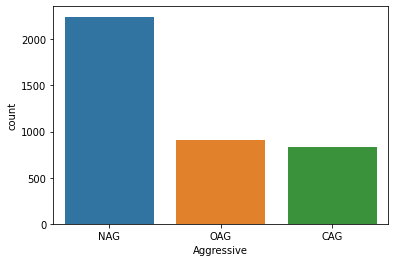

In [ ]:
sns.countplot(train['Aggressive'])

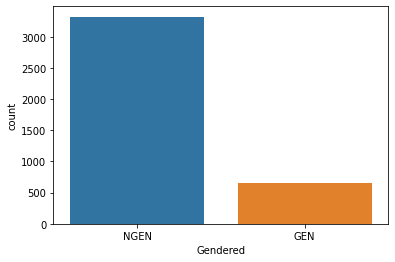

In [ ]:
sns.countplot(train['Gendered'])

In [ ]:
task_a_labels = {'NAG':0,'OAG':1,'CAG':2}
task_b_labels = {'NGEN':0,'GEN':1}

In [ ]:
train = train.replace({'Aggressive':task_a_labels,'Gendered':task_b_labels})

In [ ]:
train.head()

,ID,Text,Aggressive,Gendered
0,C4.131,Bollywood film dekhne ke samay logic ghar mein...,0,0
1,C4.638,Chutiya movie...,0,0
2,C38.598,Us jaat bnde ka khene ka matlab tha mar daluga...,1,0
3,C4.2101.1,@Feminism Is CANCER *un feminist yeh sahi hai ...,1,0
4,C29.14.2,Amrit Anand अब तो जुड़े ही है उनको बोलो जुड़ने,0,0


In [ ]:
def clean_text(text:str):

  """
  util function to clean the text
  ------------------------------
  Parameters-
  text : input text to preprocess

  Return-
  text : cleaned text
  """

  # lower case the text
  text = str(text).lower()
  # remove twitter user names
  text = re.sub('@[\w]+','',text)
  # remove hyperlinks
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.,*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

  return text

### Word Cloud

- On Train data

List of hinglish stopwords

In [ ]:
hinglish_stopwords

In [ ]:
def preprocess_text(text):

  """
  Util function to preprocess text

  Parameters:
          text(str):  

  Returns:
          text(str): preprocessed text
  """
  
  text = clean_text(text)
  text = ' '.join(token for token in text.split() if token not in hinglish_stopwords)
  return text

In [ ]:
train['Clean_Text'] = train['Text'].apply(preprocess_text)

In [ ]:
train.head()

,ID,Text,Aggressive,Gendered,Clean_Text
0,C4.131,Bollywood film dekhne ke samay logic ghar mein...,0,0,bollywood film dekhne samay logic chorke ana p...
1,C4.638,Chutiya movie...,0,0,chutiya movie
2,C38.598,Us jaat bnde ka khene ka matlab tha mar daluga...,1,0,jaat bnde khene matlab mar daluga gand fat gyi...
3,C4.2101.1,@Feminism Is CANCER *un feminist yeh sahi hai ...,1,0,cancer feminist matlab women gaali insaan rape...
4,C29.14.2,Amrit Anand अब तो जुड़े ही है उनको बोलो जुड़ने,0,0,amrit anand अब तो जुड़े ही है उनको बोलो जुड़ने


In [ ]:
def get_word_cloud(data,task=None,label=None):

  """
  Get the word cloud of the given dataset split for a given class
  ---------------------------------------------------------------
  Parameters:
  data (pd.DataFrame) - dataframe
  task (str) : Aggressive or Gendered
  label (int) : class label 

              Gendered 
              GEN -> 1
              Aggressive 
              NAG -> 0
              OAG -> 1
              CAG -> 2

  """
  
  count_vec = CountVectorizer()

  if label:
    data = data[data[task] == label]
  count_dtm = count_vec.fit_transform(data['Clean_Text'])
  words = count_vec.get_feature_names()
  word_count = count_dtm.sum(axis=0).A1
  word_dict = dict(zip(words,word_count))

  wc = WordCloud(
      background_color = 'white',
      width=1000,
      height=500
  ).generate_from_frequencies(word_dict)

  plt.figure(figsize = (13,8))
  plt.axis("off")
  plt.imshow(wc)
  plt.tight_layout(pad=0)
  plt.show()

#### Word Cloud for the entire Text Data

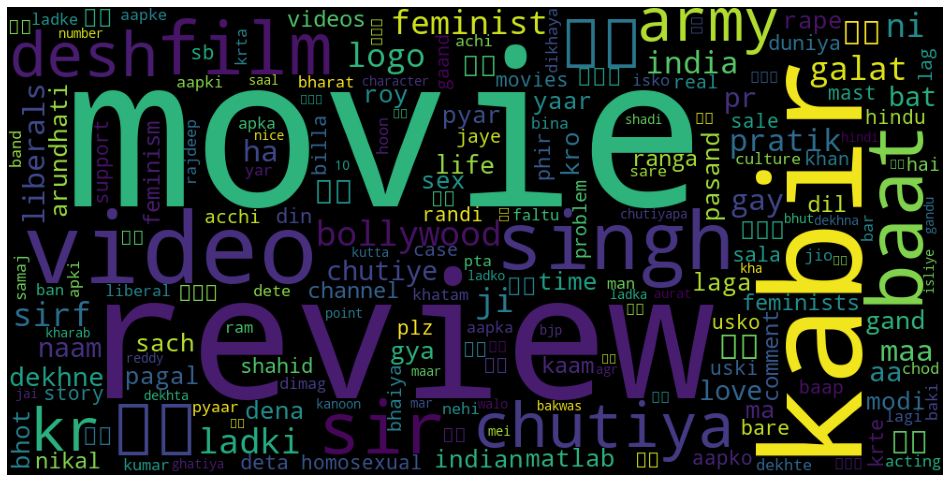

In [ ]:
get_word_cloud(train)

#### Gendered Text data (Word Cloud)

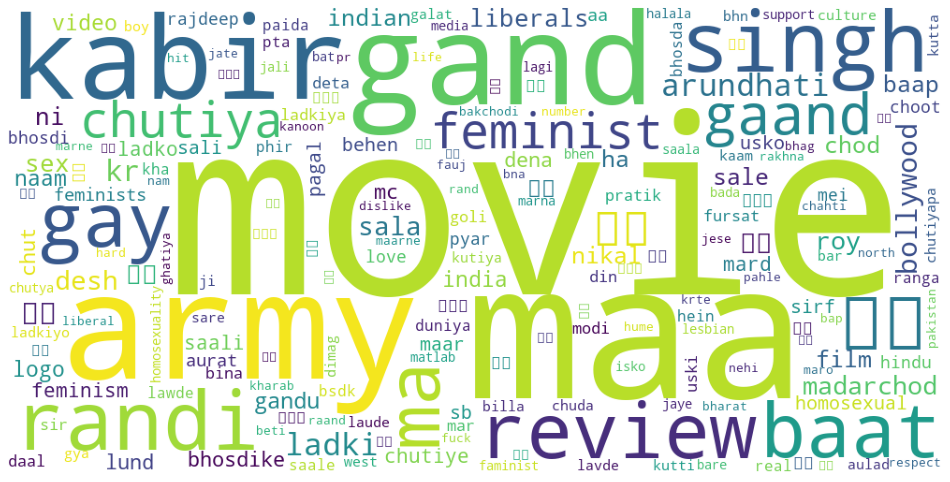

In [ ]:
get_word_cloud(train,'Gendered',1)

#### Overtly Aggresive

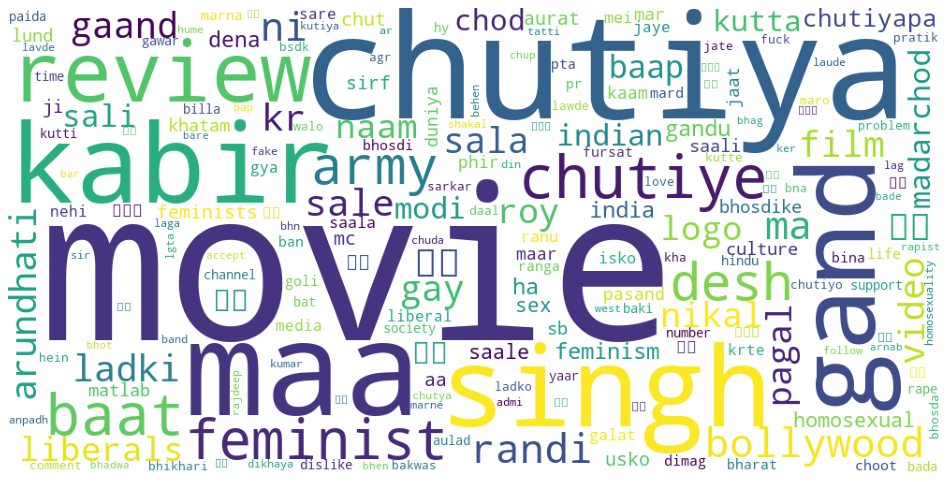

In [ ]:
get_word_cloud(train,'Aggressive',1)

### Covertly Aggressive text

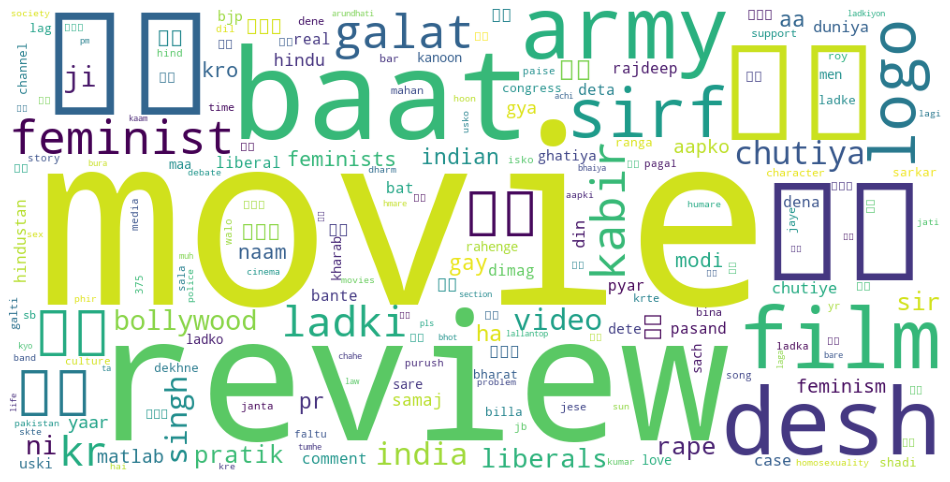

In [ ]:
get_word_cloud(train,'Aggressive',2)

### Analysizing Code switching in the data

% of Devanagri in the data

In [ ]:
train['Text']

0       Bollywood film dekhne ke samay logic ghar mein...
1                                        Chutiya movie...
2       Us jaat bnde ka khene ka matlab tha mar daluga...
3       @Feminism Is CANCER *un feminist yeh sahi hai ...
4            Amrit Anand अब तो जुड़े ही है उनको बोलो जुड़ने
                              ...                        
3979    Asexual h.. bisexual... homosexual... bhai ase...
3980    Video pura dekne ke pahile hi mai bhai ke vide...
3981                     konsa place hai bhai ...nam bolo
3982                             Kuch zada hi likh diya 🙄
3983    scary tube par kya woh karna sahi tha? Pucha k...
Name: Text, Length: 3984, dtype: object

time: 8.77 ms (started: 2021-09-02 07:14:35 +00:00)


In [ ]:
_, _, _, detected_language = cld2.detect(train['Text'][4] ,  returnVectors=True)

detected_language

((0, 12, 'Unknown', 'un'), (12, 82, 'HINDI', 'hi'))

time: 7.41 ms (started: 2021-09-02 07:36:33 +00:00)


In [ ]:
a = list(detected_language)
a

[(0, 12, 'Unknown', 'un'), (12, 82, 'HINDI', 'hi')]

time: 5.62 ms (started: 2021-09-02 07:37:56 +00:00)


In [ ]:
a[1]

(12, 82, 'HINDI', 'hi')

time: 3.46 ms (started: 2021-09-02 07:48:09 +00:00)


In [ ]:
dev_data = pd.read_csv('trac2_hin_dev.csv')

In [ ]:
def count_devanagri(data):

  """
  Count of occurences of devanagri script in the data
  --------------------------------------------------------
  Parameters:
  data (str) - dataframe


  Prints the % of data rows

  """

  count = 0 
  for text in data['Text']:
    _,_,_,detected_language = cld2.detect(text,returnVectors=True)

    lang_list = list(detected_language)
    for l in lang_list:
      if l[3]=='hi':
        count +=1 
        break
  ratio = count*100/data.shape[0]
  print(f" % of devanagri text in the training data : {ratio:.2f}, count (out of) : {count} ({data.shape[0]})")

- in train set

In [ ]:
count_devanagri(train)

 % of devanagri text in the training data : 6.98, count (out of) : 278 (3984)


- in dev set

In [ ]:
count_devanagri(dev_data)

 % of devanagri text in the training data : 7.52, count (out of) : 75 (997)
